# Создание признакового пространства

## Код из методички
### Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from string import punctuation
from nltk import ngrams
import nltk
from nltk import collocations 
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from collections import Counter

import time

### Настройки

In [2]:
DATA_PATH = './data/'
RANDOM_STATE = 404

import warnings
warnings.filterwarnings("ignore")

### Загрузка и подготовка данных

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv(DATA_PATH + 'positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv(DATA_PATH + 'negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, random_state=RANDOM_STATE)

In [5]:
nltk.download('genesis')
nltk.download('stopwords')
nltk.download('punkt')

noise = stopwords.words('russian') + list(punctuation)

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\avpat\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avpat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avpat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


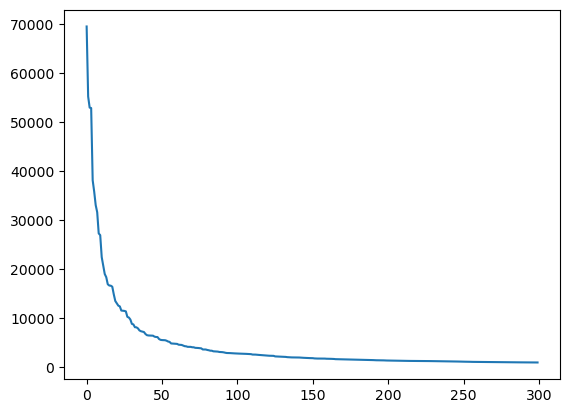

In [6]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])

first_100_freqs = [freq for word, freq in freq_dict_sorted[:300]]
plt.plot(first_100_freqs)
plt.show()

## Домашнее задание

все материалы для выполения дз в `sem2.ipynb`


### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [7]:
# Отсечки по частотности
high = 30
low = 300

high_freq = [token[0] for token in freq_dict_sorted[:high]]
medium_freq = [token[0] for token in freq_dict_sorted[high:low]]
low_freq = [token[0] for token in freq_dict_sorted[low:]]

print(high_freq)

['не', 'и', 'в', 'я', 'RT', 'на', 'http', 'что', 'с', 'а', '...', 'меня', 'у', 'как', 'так', 'D', 'это', 'мне', 'все', 'ты', 'но', "''", 'Я', '``', 'то', '..', 'по', 'уже', 'за', 'же']


In [8]:
def train_lr(stop_words):
    vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
    bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)
    lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=500)
    lr.fit(bow, y_train)
    pred = lr.predict(vec.transform(x_test))

    return pred

In [9]:
%%time

labels = ['High:', 'Medium:', 'Low:']
params = [noise+medium_freq+low_freq,
          noise+high_freq+low_freq,
          noise+high_freq+medium_freq]

for label, param in zip(labels, params):
    pred = train_lr(param)
    print(label, classification_report(pred, y_test), sep='\n')
    print('')

High:
              precision    recall  f1-score   support

    negative       0.80      0.57      0.67     38947
    positive       0.42      0.68      0.52     17762

    accuracy                           0.61     56709
   macro avg       0.61      0.63      0.59     56709
weighted avg       0.68      0.61      0.62     56709


Medium:
              precision    recall  f1-score   support

    negative       0.49      0.66      0.57     20830
    positive       0.76      0.61      0.67     35879

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.62     56709
weighted avg       0.66      0.63      0.63     56709


Low:
              precision    recall  f1-score   support

    negative       0.80      0.74      0.77     29963
    positive       0.73      0.79      0.76     26746

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.77      0.76      0.76     56709

__Вывод:__ Обучение на словах имеющих низкую частотность даёт лучшие результаты

### Задание 2.

найти фичи с наибольшей значимостью, и вывести их

На уроке мы видели, что есть значисмые фичи среди пунктуации, поэтому обучим модель вместе с ними.

In [10]:
stop_words = stopwords.words('russian')
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=500)
lr.fit(bow, y_train)
pred = lr.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27889
    positive       1.00      1.00      1.00     28820

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Выведем 30 наиболее значимых фичей.

In [11]:
# Выведем 30 важнейших признаков
feat_importance = list(zip(vec.get_feature_names_out(), lr.coef_[0]))
feat_importance = sorted(feat_importance, key=lambda x: abs(x[1]), reverse=True)[:30]

for i, feat in enumerate(feat_importance):
    print(f'{i+1}) {feat[0]}')

1) (
2) )
3) d
4) |
5) ^_^
6) -/
7) dd
8) o_o
9) о_о
10) ddd
11) do_or_die_xxx
12) to_over_kill
13) -d
14) dddd
15) белый
16) horanso_on
17) cio_optimal
18) reno_oppa
19) prisonero_o
20) ddddd
21) =^_^=
22) kota_oo_oo
23) rt
24) lponomarenko_o
25) :
26) _do_or_die__
27) do_or_pie_
28) _ooo_ooo__
29) alekseevao_o
30) dddddd


Из списка выше видно, что наиболее значимыми фичами являются части смайликов.

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [12]:
stop_words = noise+high_freq+medium_freq # Обучение со спец. символами работает слишком хорошо

params = [
    ('Count', CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)),
    ('TF-IDF', TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words))
]

for i in range(1024, 10240+1, 1024):
    params.append((f'Hashing ({i})', HashingVectorizer(n_features=i)))

for label, vectorizer in params:
    start_time = time.time()

    bow = vectorizer.fit_transform(x_train) # bow -- bag of words (мешок слов)
    lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=500)
    lr.fit(bow, y_train)
    pred = lr.predict(vectorizer.transform(x_test))
    print(f'{label} ({round(time.time() - start_time)} sec)',
          classification_report(pred, y_test),
          sep='\n')

    print('\n')

Count (24 sec)
              precision    recall  f1-score   support

    negative       0.80      0.74      0.77     29963
    positive       0.73      0.79      0.76     26746

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.77      0.76      0.76     56709



TF-IDF (18 sec)
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76     28142
    positive       0.76      0.77      0.76     28567

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Hashing (1024) (2 sec)
              precision    recall  f1-score   support

    negative       0.63      0.65      0.64     27224
    positive       0.67      0.65      0.66     29485

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg    

В данном случае CountVectorizer показал лучшие результаты.<br>
HashingVectorizer работает значительно быстрее остальных, однако предсказывает он жуже.<br>
Оптимальный размер для HashingVectorizer: 7168